<a href="https://colab.research.google.com/github/AsmaaIbrahiim/Face-Mask-Detection/blob/model_1/Face_Mask_Detection%7C_Transfer_learning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

University of Science and Technology, Zewail City <br>
Communications and Information Engineering Program <br>
CIE 555 - Deep Learning and Neural Networks <br>
Course Project - **Face Mask Detection**

# **Imports**

In [267]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
# =========================================== #
import keras.applications
from keras.models import Model
from keras.layers import Dense, Flatten,Dropout
import tensorflow as tf
#============================================== #
import numpy as np
from sklearn.metrics import classification_report

# **Dataset Import**

In [269]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
file_id = '1UXAbqllbeh14XslYxAuTOfd3hsvbmp0G'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('archive.zip')

#Get random images for testing
fild_id = '1S2GHYiYFsquDhh1xxLTj_3RtkuXaIvNA'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('random_images.zip')


In [271]:
!mkdir /content/dataset
!unzip -q /content/archive.zip -d /content/dataset 
!unzip -q /content/random_images.zip -d /content/random_test_images 

mkdir: cannot create directory ‘/content/dataset’: File exists
replace /content/dataset/Face Mask Dataset/Test/WithMask/1163.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/dataset/Face Mask Dataset/Test/WithMask/1174.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
n
replace /content/random_test_images/Face Mask Dataset/Test/WithMask/1163.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y


# **Loading data into generators + Helper Functions**

In [265]:
# General Parameters
train_dir='/content/dataset/Face Mask Dataset/Train'
val_dir='/content/dataset/Face Mask Dataset/Validation'
test_dir='/content/dataset/Face Mask Dataset/Test'
random_test_dir = '/content/random_test_images'
HEIGHT = 128
WIDTH = 128
BATCH_SIZE = 500

In [232]:
def get_generators(preprocessing_object = tf.keras.applications.vgg19.preprocess_input):
  #preprocessing_function = preprocessing_object,
  train_generator=ImageDataGenerator(
                                    rotation_range = 40,
                                    height_shift_range=(-4,4),
                                    width_shift_range = (-4,4),
                                    brightness_range = (0.3,1.7))
  val_generator=ImageDataGenerator(
                                    rotation_range = 40,
                                    height_shift_range=(-4,4),
                                    width_shift_range = (-4,4),
                                    brightness_range = (0.3,1.7))
  test_generator= ImageDataGenerator(
                                    rotation_range = 40,
                                    height_shift_range=(-4,4),
                                    width_shift_range = (-4,4),
                                    brightness_range = (0.3,1.7))

  ### Generators; train, val and test
  train_data_generator=train_generator.flow_from_directory(train_dir,
                                              target_size=(HEIGHT,WIDTH),
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                              class_mode='categorical',
                                              color_mode='rgb')

  val_data_generator=val_generator.flow_from_directory(val_dir,
                                              target_size=(HEIGHT,WIDTH),
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                              class_mode='categorical',
                                              color_mode='rgb')
  test_data_generator=test_generator.flow_from_directory(test_dir,
                                              target_size=(HEIGHT,WIDTH),
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                              class_mode='categorical',
                                              color_mode='rgb')
  return train_data_generator, val_data_generator, test_data_generator

In [233]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  #plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Categorical Cross Entropy')
  #plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [263]:
def load_img_function(img_path, show=True):

    img = load_img(img_path, target_size=(HEIGHT, WIDTH))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255.                                      

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return np.vstack([img_tensor])

In [234]:
# Generators
train_data_generator, val_data_generator, test_data_generator = get_generators(tf.keras.applications.vgg16.preprocess_input)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [235]:
images, labels = next(train_data_generator)

print(images.shape)
print(labels.shape)

(500, 128, 128, 3)
(500, 2)


# **Dataset Visualization**

In [87]:
classes = ['masked','non_masked']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

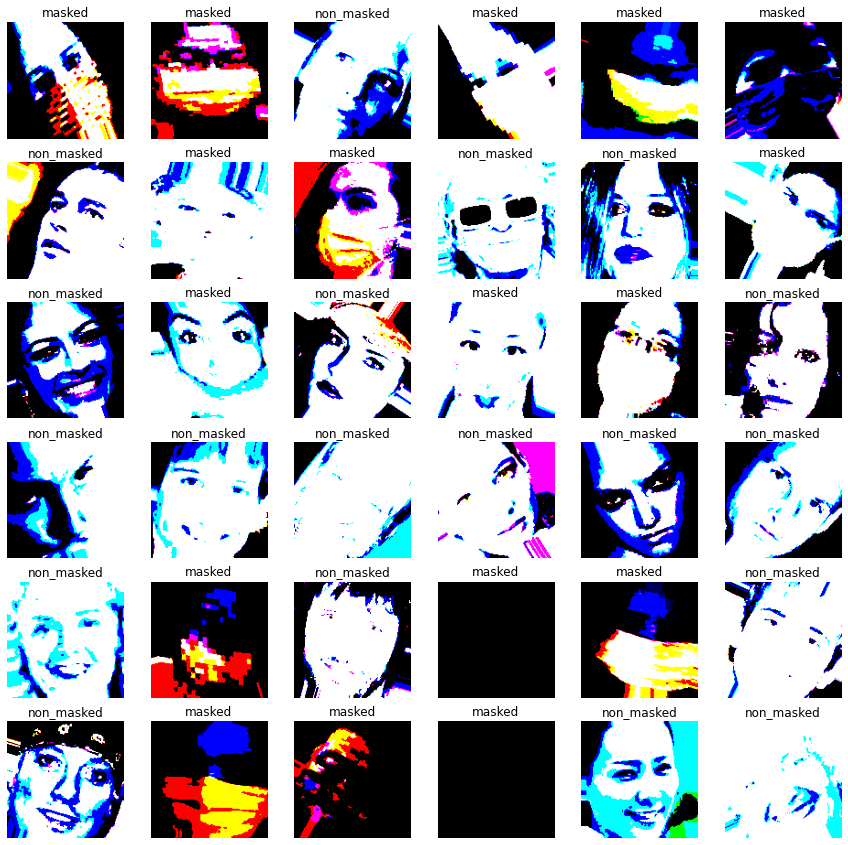

In [88]:
## train
plt.figure(figsize=(15, 15))
for i in range(36):
    ax = plt.subplot(6, 6, i + 1)
    images, labels = next(train_data_generator)
    plt.imshow(images[i])
    plt.title(classes[int(np.argmax(labels[i]))])
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

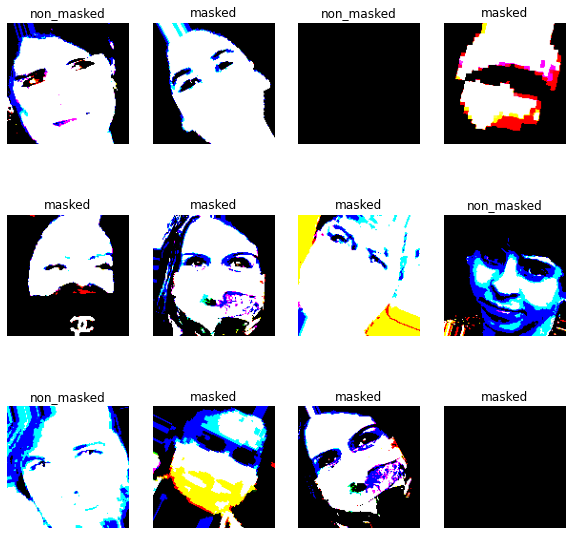

In [89]:
## validation
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    images, labels = next(val_data_generator)
    plt.imshow(images[i])
    plt.title(classes[int(np.argmax(labels[i]))])
    plt.axis("off")

# **Models**

*As one of the most popular and effect transfer learning model in use of images, VGG16 model is tried on our dataset.*

## **First Model**: VGG16

**Why it can work?**<br>
VGG16 layers are all convolutional layers with 3x3 kernels and 2x2 max pooling layers untill the 3 final dense layers. Hence, we think that VGG architecture is suitable for capturing small features variantions in the input layer and wider variations in the consecutive layers of the features space. This is practically seems useful as the deeper we go in the images in this project the less important the details are. Also, the input layer for VGG16 is RGB images which is totally important for this project to caputure the mask color variations.

The first trial is just using the pre-trained model with minimum contribution

In [94]:
from keras.applications.vgg16 import VGG16

# Load model without classification head
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Mark loaded layers as not trainable
for layer in base_model.layers:
  layer.trainable = False

# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Print summary
model.summary()

# Compile
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0  

**Let's train the model!!**

In [95]:
# I can choose small number of epochs for initial investigation for the model perfomance
INITIAL_EPOCHS = 5

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 55s 3s/step - loss: 2.5164 - accuracy: 0.7070 - val_loss: 0.7702 - val_accuracy: 0.8900
Epoch 2/5
20/20 [==============================] - 53s 3s/step - loss: 0.7050 - accuracy: 0.9057 - val_loss: 0.4461 - val_accuracy: 0.9380
Epoch 3/5
20/20 [==============================] - 53s 3s/step - loss: 0.4647 - accuracy: 0.9334 - val_loss: 0.5372 - val_accuracy: 0.9380
Epoch 4/5
20/20 [==============================] - 54s 3s/step - loss: 0.4288 - accuracy: 0.9426 - val_loss: 0.3744 - val_accuracy: 0.9460
Epoch 5/5
20/20 [==============================] - 53s 3s/step - loss: 0.3419 - accuracy: 0.9505 - val_loss: 0.4519 - val_accuracy: 0.9480


The VGG16 model seems promising but relatively slow, hence we're going to raise the learning rate to notice its effect.

In [96]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.01
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 56s 3s/step - loss: 2.8872 - accuracy: 0.8926 - val_loss: 0.1533 - val_accuracy: 0.9900
Epoch 2/5
20/20 [==============================] - 54s 3s/step - loss: 0.1747 - accuracy: 0.9919 - val_loss: 0.0684 - val_accuracy: 0.9920
Epoch 3/5
20/20 [==============================] - 54s 3s/step - loss: 0.0917 - accuracy: 0.9922 - val_loss: 0.0844 - val_accuracy: 0.9940
Epoch 4/5
20/20 [==============================] - 54s 3s/step - loss: 0.0933 - accuracy: 0.9929 - val_loss: 0.0333 - val_accuracy: 0.9960
Epoch 5/5
20/20 [==============================] - 53s 3s/step - loss: 0.0286 - accuracy: 0.9938 - val_loss: 0.1728 - val_accuracy: 0.9880


Yes, that's right! The model behaves better with higher learning rate. Let's try the same model with different optimizer (Adam).

In [97]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.01
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 56s 3s/step - loss: 14.7555 - accuracy: 0.8650 - val_loss: 0.7287 - val_accuracy: 0.9720
Epoch 2/5
20/20 [==============================] - 54s 3s/step - loss: 0.4989 - accuracy: 0.9884 - val_loss: 0.1427 - val_accuracy: 0.9860
Epoch 3/5
20/20 [==============================] - 54s 3s/step - loss: 0.1154 - accuracy: 0.9936 - val_loss: 0.1124 - val_accuracy: 0.9980
Epoch 4/5
20/20 [==============================] - 54s 3s/step - loss: 0.0997 - accuracy: 0.9958 - val_loss: 0.1270 - val_accuracy: 0.9880
Epoch 5/5
20/20 [==============================] - 53s 3s/step - loss: 0.0459 - accuracy: 0.9943 - val_loss: 0.0675 - val_accuracy: 0.9960


Adam Optimizer has already boosted the model behavior. The next step is to include more layers for robustness in addition to dropout layers to somehow avoid overfitting.

In [237]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.01
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = 15,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/15
20/20 [==============================] - 57s 3s/step - loss: 46.6172 - accuracy: 0.6981 - val_loss: 0.4409 - val_accuracy: 0.9660
Epoch 2/15
20/20 [==============================] - 53s 3s/step - loss: 0.9039 - accuracy: 0.9626 - val_loss: 0.1348 - val_accuracy: 0.9800
Epoch 3/15
20/20 [==============================] - 53s 3s/step - loss: 0.3531 - accuracy: 0.9710 - val_loss: 0.0469 - val_accuracy: 0.9860
Epoch 4/15
20/20 [==============================] - 53s 3s/step - loss: 0.1722 - accuracy: 0.9759 - val_loss: 0.0498 - val_accuracy: 0.9900
Epoch 5/15
20/20 [==============================] - 53s 3s/step - loss: 0.1069 - accuracy: 0.9785 - val_loss: 0.0261 - val_accuracy: 0.9920
Epoch 6/15
20/20 [==============================] - 53s 3s/step - loss: 0.0940 - accuracy: 0.9770 - val_loss: 0.0377 - val_accuracy: 0.9880
Epoch 7/15
20/20 [==============================] - 53s 3s/step - loss: 0.0761 - accuracy: 0.9781 - val_loss: 0.0364 - val_accuracy: 0.9880
Epoch 8/15
20/20 [=

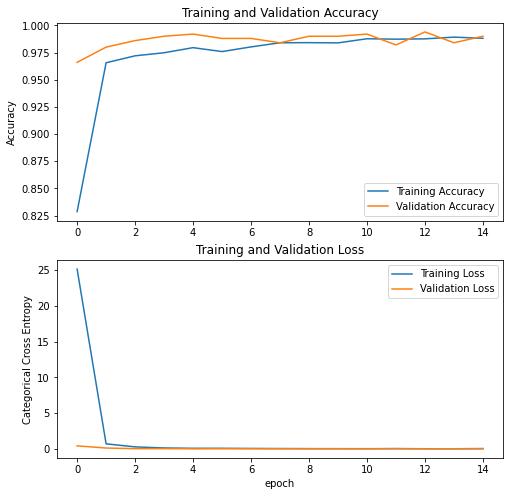

In [238]:
plot_history(history)

In [241]:
# Evaluation on test data !
print(model.metrics_names)
model.evaluate(test_data_generator, batch_size=BATCH_SIZE, steps=20)

['loss', 'accuracy']
20/20 [==============================] - 5s 122ms/step - loss: 0.0390 - accuracy: 0.9909


[0.03903891146183014, 0.9909273982048035]

**Let's show the classificaction report (Percision, recall, F1-Score)**

We're more interested in the RECALL metric. This is because the non-maksed class is the TURE (POSITIVE) class and we're concerned with avoiding classifing non-masked as masked. Hence, we're more strict againt FALSE NEGATIVE class. So, RECALL metric is the more important that PRECISION.

In [242]:
# We're testing on 500 images (The generator size)
image_samples, label_samples = next(test_data_generator)
y_pred = np.argmax(model.predict(image_samples), axis=1)
print(classification_report(np.argmax(label_samples, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       233
           1       1.00      0.98      0.99       259

    accuracy                           0.99       492
   macro avg       0.99      0.99      0.99       492
weighted avg       0.99      0.99      0.99       492



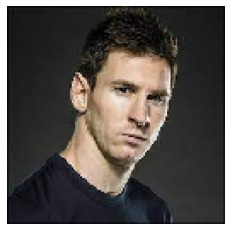

'non_masked'

In [264]:
test_img = load_img_function('messi.jpeg')
classes[np.argmax(model.predict(images))]

In [125]:
#test_img = tf.keras.preprocessing.image.load_img('DL1.png', target_size=(HEIGHT, WIDTH, 3))
test_img = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img('DL3.png', target_size=(HEIGHT, WIDTH, 3)))
#test_arr = np.array([test_img])
y = model.predict(test_arr)
y

ValueError: ignored

In [197]:
  test_generator= ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)
  random_test_generator=test_generator.flow_from_directory('/content/random_images',
                                              target_size=(HEIGHT,WIDTH),
                                              batch_size = 1,
                                              shuffle = True,
                                              class_mode='categorical',
                                              color_mode='rgb')
  #random_test_pred = model.predict(random_test_generator)

Found 3 images belonging to 3 classes.


**Great! We acheived the required performance with VGG16 model**

In [103]:
# Save the model!
model.save('face_mask_detection_vgg16.h5')

### **Loading the model**

In [104]:
vgg16_model = keras.models.load_model('face_mask_detection_vgg16.h5')

In [28]:
vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   